# USA Real Estate Analyzing Time-Series Data

### This notebook contains:

I. libraries and data import

II. subsetting, wrangling, and cleaning data

III. time-series decomposition

IV. testing for data stationarity

V. stationarizing the data

## I. libraries and data import

In [1]:
import nasdaqdatalink # the newer version of quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 

warnings.filterwarnings("ignore") # disable deprecation warnings that could indicate, for instance, a suspended library or feature

plt.style.use('fivethirtyeight') # a styling option for how your plots will appear

In [3]:
# graphs are displayed in notebook
%matplotlib inline

In [5]:
# create path shortcut
path = r'C:\Users\lisag\Desktop\CF Work\Immersion 6 Tasks'

In [7]:
# import USA real estate data
df = pd.read_csv(os.path.join(path, 'USA Real Estate Final.csv'))

In [9]:
df.head()

,Unnamed: 0,Broker Number,House Status,House Price,N. Beds,N. Baths,N. Acres,City,State,Zip Code,House SQFT,Last Sell Date
0,0,103378.0,for_sale,105000.0,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0,1970-01-01
1,1,52707.0,for_sale,80000.0,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0,1970-01-01
2,2,103379.0,for_sale,67000.0,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0,1970-01-01
3,3,31239.0,for_sale,145000.0,4.0,2.0,0.10,Ponce,Puerto Rico,731.0,1800.0,1970-01-01
4,4,103378.0,for_sale,179000.0,4.0,3.0,0.46,San Sebastian,Puerto Rico,612.0,2520.0,1970-01-01


## II. subsetting, wrangling, and cleaning data

In [12]:
# recurring data cleaning
# drop 'Unnamed: 0' column
df = df.drop(columns = ['Unnamed: 0'])
# change 'brokered_by' to object/string data type
df['Broker Number'] = df['Broker Number'].astype('str')
# change 'zip_code' to object/string data type
df['Zip Code'] = df['Zip Code'].astype('str')
# convert to datetime format and replace zeros will NaT (Not a Time)
df['Last Sell Date'] = pd.to_datetime(df['Last Sell Date'], errors='coerce')

In [14]:
df.dtypes

Broker Number             object
House Status              object
House Price              float64
N. Beds                  float64
N. Baths                 float64
N. Acres                 float64
City                      object
State                     object
Zip Code                  object
House SQFT               float64
Last Sell Date    datetime64[ns]
dtype: object

In [16]:
# drop irrelevant columns
df.drop(columns=['Broker Number', 'House Status', 'N. Beds', 'N. Baths', 'N. Acres',
                          'City', 'State', 'Zip Code', 'House SQFT'], inplace=True)

In [18]:
df.head()

,House Price,Last Sell Date
0,105000.0,1970-01-01
1,80000.0,1970-01-01
2,67000.0,1970-01-01
3,145000.0,1970-01-01
4,179000.0,1970-01-01


In [20]:
# extract only the year
df["Last Sell Date"] = pd.to_datetime(df["Last Sell Date"])
df["year"] = df["Last Sell Date"].dt.year  

In [22]:
df.head()

,House Price,Last Sell Date,year
0,105000.0,1970-01-01,1970
1,80000.0,1970-01-01,1970
2,67000.0,1970-01-01,1970
3,145000.0,1970-01-01,1970
4,179000.0,1970-01-01,1970


In [24]:
# drop irrelevant redundant column
df.drop(columns=['Last Sell Date'], inplace=True)

In [26]:
# set date as index column
df.set_index("year", inplace=True)

In [28]:
# group years by average house price
df_yearly = df.groupby("year")["House Price"].mean().reset_index()

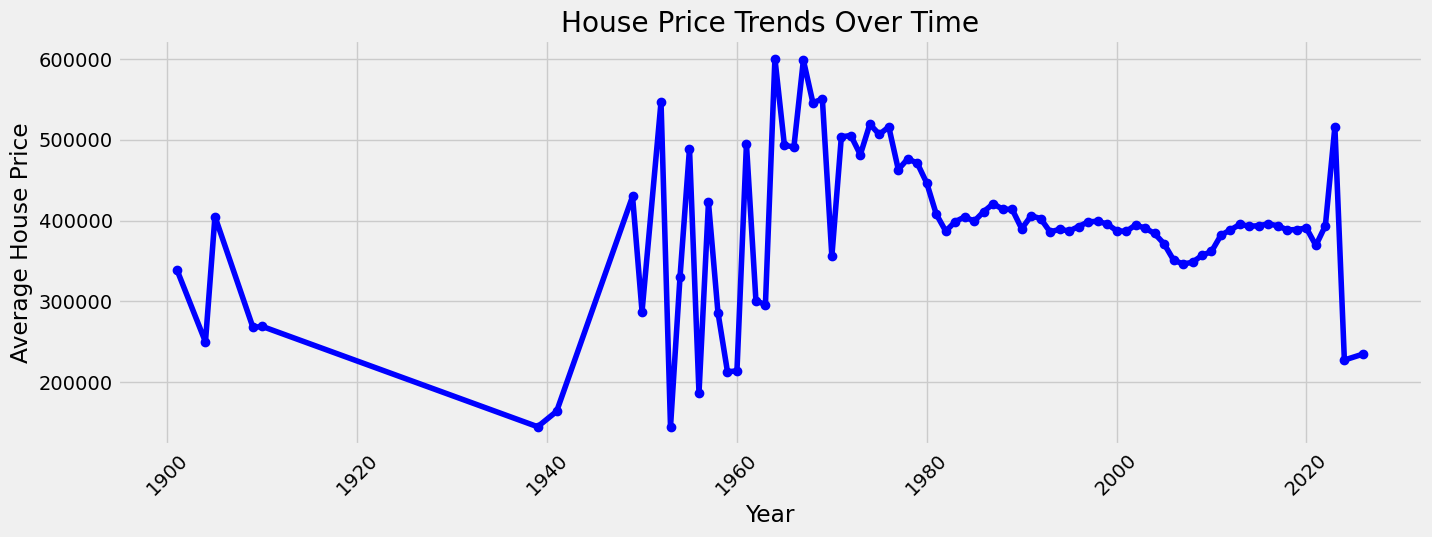

In [30]:
# plot the data using matplotlib
plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_yearly["year"], df_yearly["House Price"], marker="o", linestyle="-", color="b")

plt.xlabel("Year")
plt.ylabel("Average House Price")
plt.title("House Price Trends Over Time")
plt.xticks(rotation=45)  # rotate labels for readability
plt.grid(True)
plt.show()

In [32]:
# reset index to use the "year" column as a filter
data = df.reset_index()

In [34]:
data.describe

<bound method NDFrame.describe of          year  House Price
0        1970     105000.0
1        1970      80000.0
2        1970      67000.0
3        1970     145000.0
4        1970     179000.0
...       ...          ...
1083012  2022     339900.0
1083013  2022     359900.0
1083014  2022     350000.0
1083015  2022     179900.0
1083016  2022     580000.0

[1083017 rows x 2 columns]>

In [36]:
data.head()

,year,House Price
0,1970,105000.0
1,1970,80000.0
2,1970,67000.0
3,1970,145000.0
4,1970,179000.0


In [38]:
data.dtypes

year             int32
House Price    float64
dtype: object

In [40]:
# change 'year' to float64
data['year'] = data['year'].astype('float64')

In [42]:
data.dtypes

year           float64
House Price    float64
dtype: object

In [44]:
# narrowing to fifty years of recent data in a data subset
data_sub = data.loc[(data['year'] >= 1972) & (data['year'] < 2022)]

In [46]:
# group years by average house price
data_plot = data_sub.groupby("year")["House Price"].mean().reset_index()

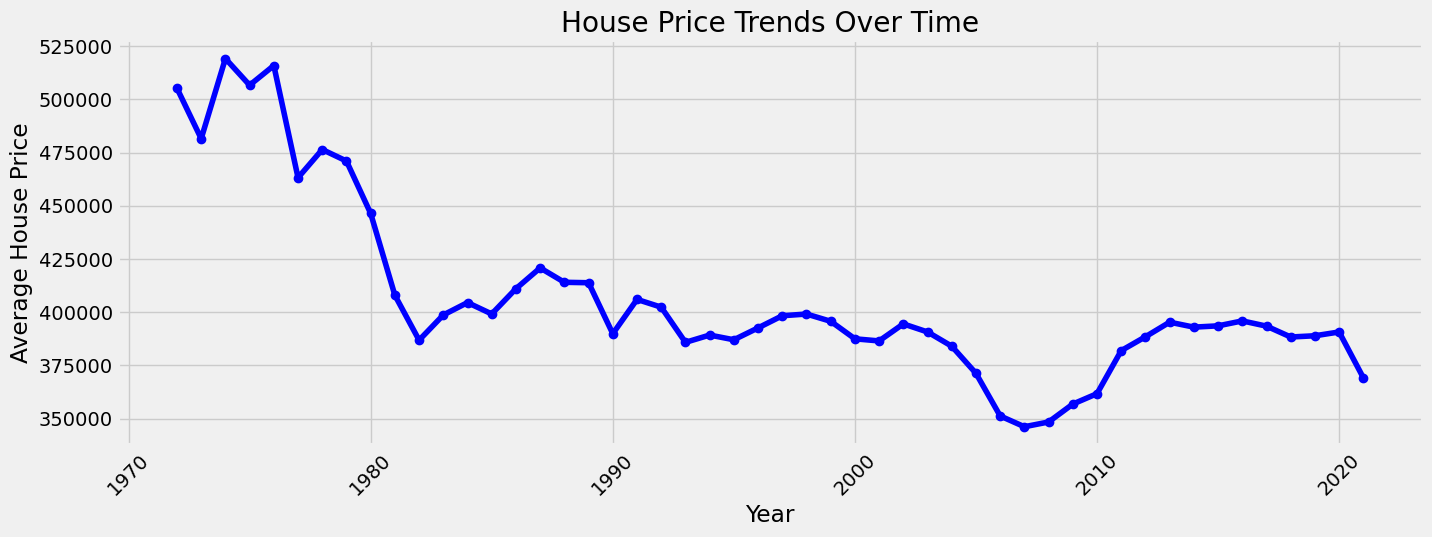

In [48]:
# plot the data using matplotlib
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_plot["year"], data_plot["House Price"], marker="o", linestyle="-", color="b")

plt.xlabel("Year")
plt.ylabel("Average House Price")
plt.title("House Price Trends Over Time")
plt.xticks(rotation=45)  # rotate labels for readability
plt.grid(True)
plt.show()

In [50]:
# check for missing values
data_plot.isnull().sum() # none

year           0
House Price    0
dtype: int64

In [52]:
# check for duplicates
dups = data_plot.duplicated()
dups.sum() # none

0

## III. time-series decomposition

In [55]:
# convert to datetime format and replace zeros will NaT (Not a Time)
data_plot['year'] = pd.to_datetime(data_plot['year'], errors='coerce')

In [57]:
# set date as index column
data_plot.set_index("year", inplace=True)

In [61]:
# decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(data_plot["House Price"], model='additive', period=1)

In [63]:
# define a fixed size for all special charts
from pylab import rcParams 
rcParams['figure.figsize'] = 18, 7

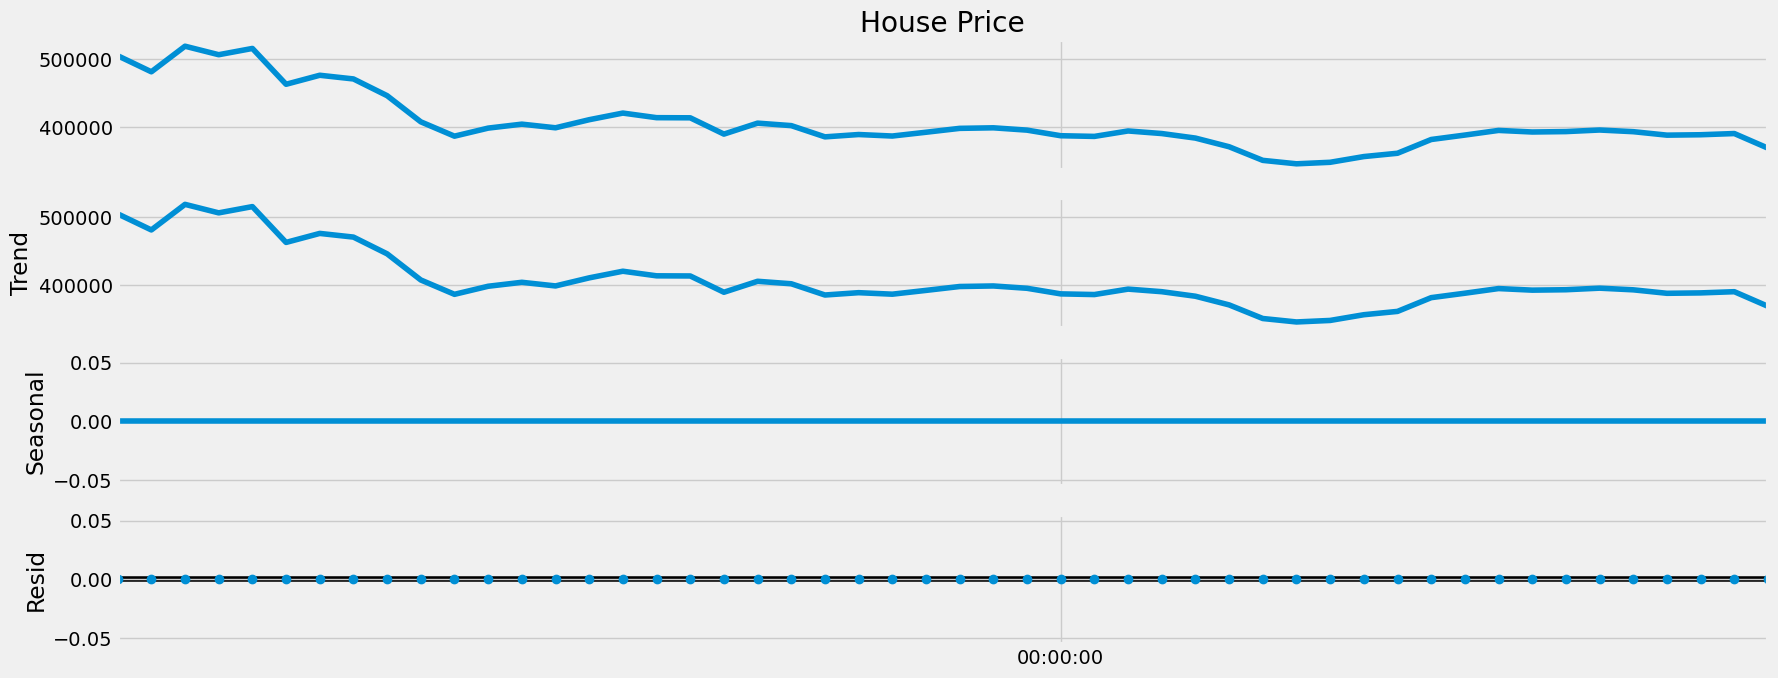

In [65]:
# plot the separate components
decomposition.plot()
plt.show()

this chart shows a general downward trend in the data, but no seasonality and no noise in the data

## IV. testing for stationarity

In [71]:
# import the adfuller() function
from statsmodels.tsa.stattools import adfuller 

def dickey_fuller(timeseries): # define the function
    # perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

dickey_fuller(data_plot['House Price'])

Dickey-Fuller Stationarity test:
Test Statistic                 -2.270492
p-value                         0.181661
Number of Lags Used             0.000000
Number of Observations Used    49.000000
Critical Value (1%)            -3.571472
Critical Value (5%)            -2.922629
Critical Value (10%)           -2.599336
dtype: float64


this test indicates that the data is not stationary, as the test statistic is greater than the critical value

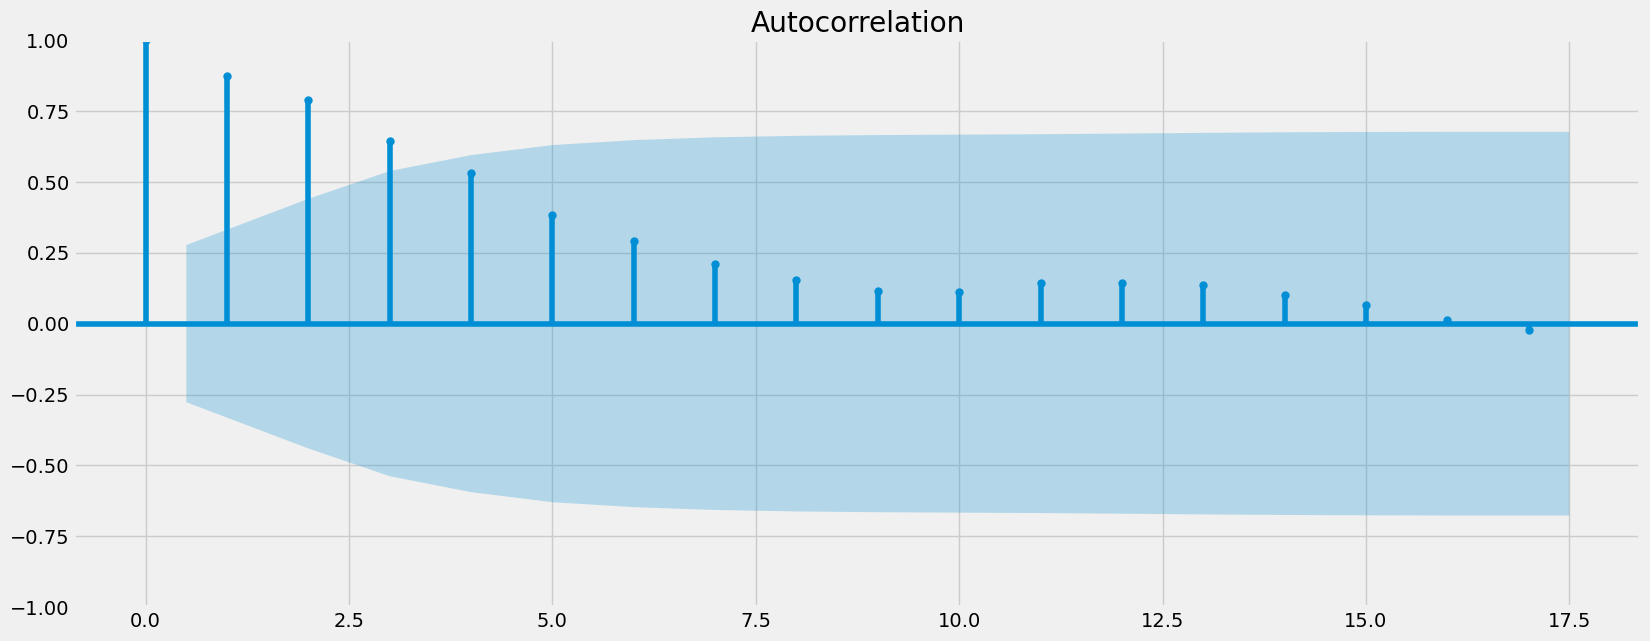

In [74]:
# check plot for autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # import the autocorrelation and partial correlation plots

plot_acf(data_plot)
plt.show()

this indicates that there is some amount of lags that are correlated with one another, indicating that this data is autocorrelated and thus not stationary

## V. stationarizing the data

In [78]:
# make a set of data that is t - (t -1)
data_diff = data_plot - data_plot.shift(1) 

In [80]:
# remove the missing values that came about as a result of the differencing
data_diff.dropna(inplace = True) 

In [82]:
data_diff.head()

,House Price
year,
1970-01-01 00:00:00.000001973,-23687.173580
1970-01-01 00:00:00.000001974,37616.411057
1970-01-01 00:00:00.000001975,-12501.391423
1970-01-01 00:00:00.000001976,9212.655153
1970-01-01 00:00:00.000001977,-52665.318688


In [84]:
data_diff.columns

Index(['House Price'], dtype='object')

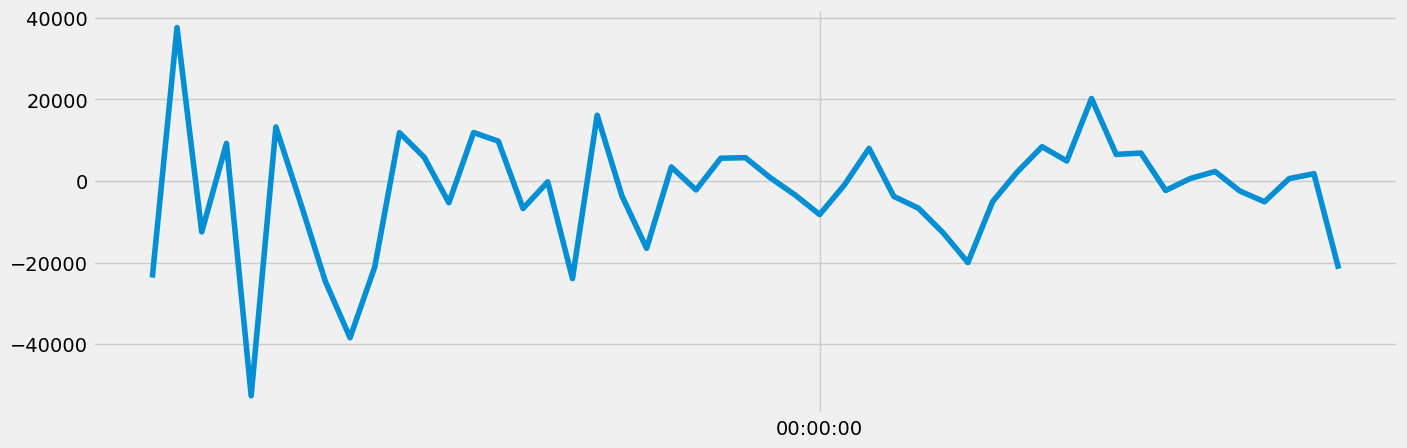

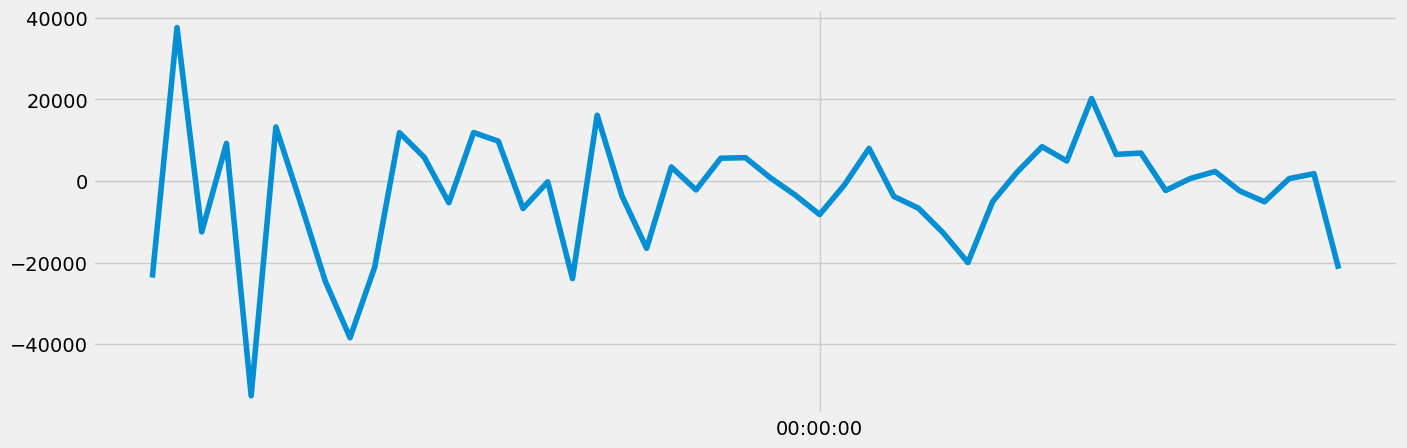

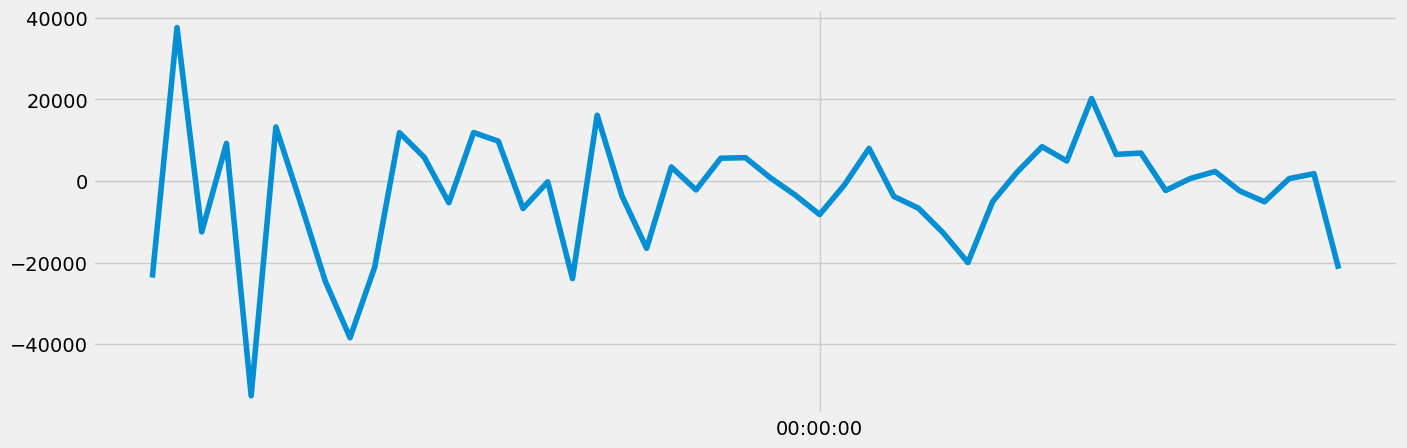

In [90]:
# check what differencing did to the time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)
plt.show()

In [92]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -7.500474e+00
p-value                        4.266837e-11
Number of Lags Used            0.000000e+00
Number of Observations Used    4.800000e+01
Critical Value (1%)           -3.574589e+00
Critical Value (5%)           -2.923954e+00
Critical Value (10%)          -2.600039e+00
dtype: float64


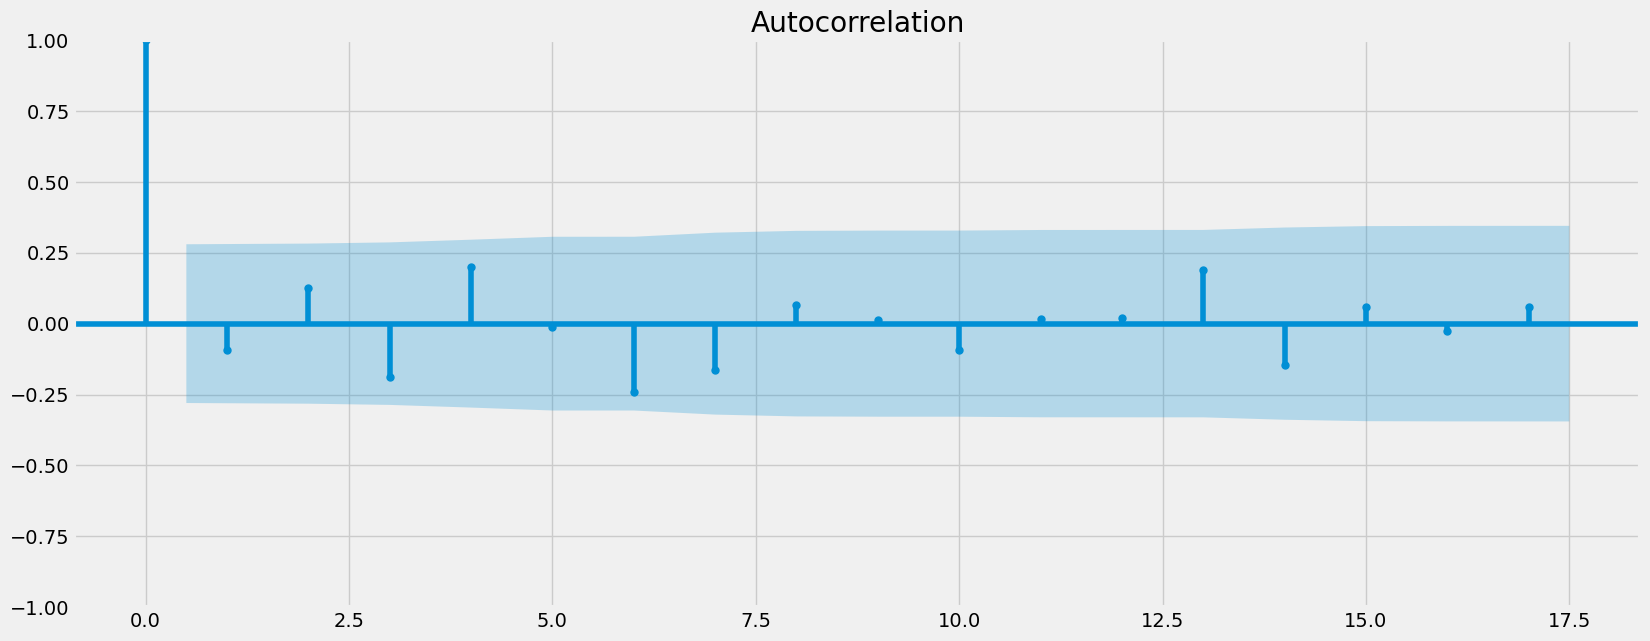

In [94]:
plot_acf(data_diff)
plt.show()

this new Dickey Fuller Test and autocorreltation chart would indicate that the data is now stationary and the data is now prepared for forecasting